In [1]:
import polars as pl
import pandas as pd
import os
import re
from datetime import datetime
from pathlib import Path

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold

from scorta.utils.logger import timing_logger

from tqdm import tqdm
from typing import TypeAlias, Literal
import polars.selectors as cs

In [3]:
from pathlib import Path
from typing import TypeAlias, Literal
import pandas as pd
import polars as pl

exp_name = "001_baseline"
input_dir = Path("../input")
output_dir = Path("../output") / exp_name
output_dir.mkdir(parents=True, exist_ok=True)

DataFrame: TypeAlias = pl.DataFrame | pd.DataFrame
DfType: TypeAlias = Literal["pl", "pd"]


class AtmaData16Loader:
    def __init__(self, input_dir: str | Path):
        self.input_dir = input_dir
        self.csv_paths = input_dir.glob("*.csv")

    def csv2parquet(self):
        for csv_path in tqdm(self.csv_paths):
            parquet_path = self.input_dir / Path(csv_path.stem + ".parquet")
            pl.read_csv(csv_path).write_parquet(parquet_path)

    @staticmethod
    def _load_parquet(path: Path, frame_type: DfType) -> DataFrame:
        return pl.read_parquet(path) if frame_type == "pl" else pd.read_parquet(path)

    def load_test_log(self, frame_type: DfType = "pl") -> DataFrame:
        return self._load_parquet(self.input_dir / "test_log.parquet", frame_type)

    def load_train_log(self, frame_type: DfType = "pl") -> DataFrame:
        return self._load_parquet(self.input_dir / "train_log.parquet", frame_type)

    def load_all_log(self, frame_type: DfType = "pl") -> DataFrame:
        df = pl.concat([self.load_train_log("pl"), self.load_test_log("pl")])
        return df if frame_type == "pl" else df.to_pandas()

    def load_ses2idx(self) -> tuple[dict[int, str], dict[str, int]]:
        idx2ses = dict(enumerate(dl.load_all_log("pd")["session_id"].unique()))
        ses2idx = {k: idx for idx, k in idx2ses.items()}
        assert ses2idx["000007603d533d30453cc45d0f3d119f"] == 0
        assert idx2ses[0] == "000007603d533d30453cc45d0f3d119f"
        return idx2ses, ses2idx

    def load_train_label(self, frame_type: DfType = "pl") -> DataFrame:
        return self._load_parquet(self.input_dir / "train_label.parquet", frame_type)

    def load_yado(self, frame_type: DfType = "pl") -> DataFrame:
        return self._load_parquet(self.input_dir / "yado.parquet", frame_type)

    def load_all_dfs(self, frame_type: DfType = "pl") -> dict[str, DataFrame]:
        return {path.stem: self._load_parquet(path, frame_type) for path in self.input_dir.glob("*.parquet")}

    def load_sample_submission(self, frame_type: DfType = "pl") -> DataFrame:
        return self._load_parquet(self.input_dir / "sample_submission.parquet", frame_type)


dl = AtmaData16Loader(input_dir)
dl.csv2parquet()
idx2ses, ses2idx = dl.load_ses2idx()


def convert_ses2idx(df: pl.DataFrame, col: str = "session_id") -> pl.DataFrame:
    return df.with_columns(pl.col(col).replace(ses2idx, default=None))


def convert_idx2ses(df: pl.DataFrame, col: str = "session_id") -> pl.DataFrame:
    return df.with_columns(pl.col(col).replace(idx2ses, default=None))


train_label = convert_ses2idx(dl.load_train_label())
all_log = convert_ses2idx(dl.load_all_log())
sample_sub = dl.load_sample_submission()


# dl.csv2parquet()

In [4]:
item2item_df = (
    all_log.join(all_log, on="session_id")
    .filter(pl.col("yad_no") != pl.col("yad_no_right"))
    .group_by("yad_no", "yad_no_right")
    .count()
)

In [5]:
top30_yad = all_log.group_by("yad_no").count().sort("count", descending=True).head(30)

In [6]:
raw_train_df = convert_ses2idx(dl.load_train_log()).join(
    item2item_df, how="left", left_on="yad_no", right_on="yad_no_right"
)
raw_test_df = convert_ses2idx(dl.load_test_log()).join(
    item2item_df, how="left", left_on="yad_no", right_on="yad_no_right"
)

In [7]:
train_label = train_label.with_columns(pl.lit(1).alias("label"))

In [8]:
raw_train_df = raw_train_df.join(
    train_label, how="left", left_on=["session_id", "yad_no_right"], right_on=["session_id", "yad_no"]
).fill_null(0)

In [31]:
yado_feat = dl.load_yado().select(~cs.string())

raw_train_df = raw_train_df.join(yado_feat, how="left", on="yad_no")
raw_test_df = raw_test_df.join(yado_feat, how="left", on="yad_no")

In [10]:
X_train = raw_train_df.drop("label")
y_train = raw_train_df["label"]

In [19]:
params = {
    "objective": "binary",
    "n_estimators": 100,
    "early_stopping_rounds": 30,
    "verbosity": -1,
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": int(2**7 * 0.7),
    "min_child_samples": 100,
    "max_depth": 7,
    "bagging_seed": 0,
    "feature_fraction": 0.4940013899320794,
    "bagging_fraction": 0.8064461585846633,
    "reg_alpha": 0.0035890288845849996,
    "reg_lambda": 0.6534787410635157,
    "max_bin": 200,
    "bagging_freq": 2,
    "device": "gpu",
}

cat_params = {}

cat_params = {
    "iterations": 1000,
    "learning_rate": 0.01,
    "depth": 6,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "random_seed": 42,
    "early_stopping_rounds": 50,
}

In [20]:
from scorta.model.gradient_boost import GBTWrapper

gbdt = GBTWrapper("cat", "bin")
models, oof = gbdt.fit(X_train.to_pandas(), y_train.to_pandas(), params=cat_params)

Learning rate set to 0.204062
0:	learn: 0.1611465	test: 0.1611395	best: 0.1611395 (0)	total: 303ms	remaining: 5m 2s
1:	learn: 0.1606155	test: 0.1606031	best: 0.1606031 (1)	total: 435ms	remaining: 3m 37s
2:	learn: 0.1602677	test: 0.1602520	best: 0.1602520 (2)	total: 558ms	remaining: 3m 5s
3:	learn: 0.1599992	test: 0.1599799	best: 0.1599799 (3)	total: 742ms	remaining: 3m 4s
4:	learn: 0.1598296	test: 0.1598084	best: 0.1598084 (4)	total: 960ms	remaining: 3m 11s
5:	learn: 0.1596708	test: 0.1596497	best: 0.1596497 (5)	total: 1.09s	remaining: 3m
6:	learn: 0.1595646	test: 0.1595407	best: 0.1595407 (6)	total: 1.21s	remaining: 2m 52s
7:	learn: 0.1594802	test: 0.1594579	best: 0.1594579 (7)	total: 1.33s	remaining: 2m 44s
8:	learn: 0.1594197	test: 0.1593999	best: 0.1593999 (8)	total: 1.45s	remaining: 2m 39s
9:	learn: 0.1593667	test: 0.1593486	best: 0.1593486 (9)	total: 1.56s	remaining: 2m 34s
10:	learn: 0.1593265	test: 0.1593069	best: 0.1593069 (10)	total: 1.66s	remaining: 2m 29s
11:	learn: 0.15929

In [ ]:
def apk(actual: int, predicted: list[int], k: int = 10) -> float:
    if actual in predicted[:k]:
        return 1.0 / (predicted[:k].index(actual) + 1)
    return 0.0


def mapk(actual: list[int], predicted: list[list[int]], k: int = 10):
    return sum(apk(a, p, k) for a, p in zip(actual, predicted)) / len(actual)


y_true = [1, 2, 3]  # Actual items
y_pred = [[1, 2, 4], [4, 1, 3], [1, 2, 3, 5]]
mapk(y_true, y_pred, 3)

In [21]:
preds = np.array([gbdt.predict(raw_test_df.to_pandas(), i) for i in range(5)]).mean(axis=0)

In [22]:
sub = raw_test_df.with_columns(pl.series(preds).alias("score"))[["session_id", "yad_no_right", "score"]]

In [93]:
# oof[:, 1]
oof_df = (
    raw_train_df[["session_id", "seq_no", "yad_no_right", "label"]]
    .with_columns(pl.Series(oof[:, 1]).alias("score"))
    .sort(["session_id", "score"], descending=(False, True))
    .with_columns(pl.col("score").rank(method="ordinal", descending=True).over("session_id").alias("rank"))
    .filter(pl.col("rank") <= 10)
)

oof_lists = oof_df.group_by("session_id", maintain_order=True).agg(pl.col("yad_no_right"))["yad_no_right"].to_list()
y_true = train_label["yad_no"].to_list()
assert len(oof_lists) == len(y_true)
mapk(y_true, oof_lists, 10)

0.1966321674969617

In [98]:
# fiiled empty
seened_dict: dict[int, np.ndarray] = (
    convert_ses2idx(dl.load_train_log())
    .with_columns([(pl.col("seq_no").max().over("session_id") == pl.col("seq_no")).alias("is_last")])
    .filter(~pl.col("is_last"))
    .group_by("session_id")
    .agg("yad_no")
    .sort("session_id")
    .to_pandas()
    .set_index("session_id")
    .to_dict()["yad_no"]
)
top_yads = top30_yad["yad_no"].to_list()

filled_empty_oof_lists = []
for idx, oof_list in enumerate(oof_lists):
    new_oof_list = []
    new_oof_list.extend(oof_list)
    if len(oof_list) < 10:
        if idx in seened_dict:
            new_oof_list.extend(list(seened_dict[idx]))
        new_oof_list.extend(top_yads[:10])

    filled_empty_oof_lists.append(new_oof_list[:10])

print(oof_lists[:5])
print(filled_empty_oof_lists[:5])

mapk(y_true, filled_empty_oof_lists, 10)

[[11882, 2808, 5289, 4101], [8253, 8747, 3725, 4488, 1586, 2570, 11104, 2259], [5238, 9039], [626, 755, 11715, 2272, 109, 7812, 1341, 121, 13549, 13296], [96, 3894, 7749, 5490, 11380, 902, 254, 4072, 10915, 1284]]
[[11882, 2808, 5289, 4101, 12350, 719, 3338, 13468, 10095, 8567], [8253, 8747, 3725, 4488, 1586, 2570, 11104, 2259, 12350, 719], [5238, 9039, 12350, 719, 3338, 13468, 10095, 8567, 532, 8553], [626, 755, 11715, 2272, 109, 7812, 1341, 121, 13549, 13296], [96, 3894, 7749, 5490, 11380, 902, 254, 4072, 10915, 1284]]


0.19664222496680403

/Users/zerebom/Library/Caches/pypoetry/virtualenvs/atma-16-GUsyrwfA-py3.11/lib/python3.11/site-packages/scorta/eda/df.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=feature_importance_df, y="column", x="feature_importance", order=order, ax=ax, palette="viridis")


(<Figure size 1200x400 with 1 Axes>,
 <Axes: xlabel='feature_importance', ylabel='column'>)

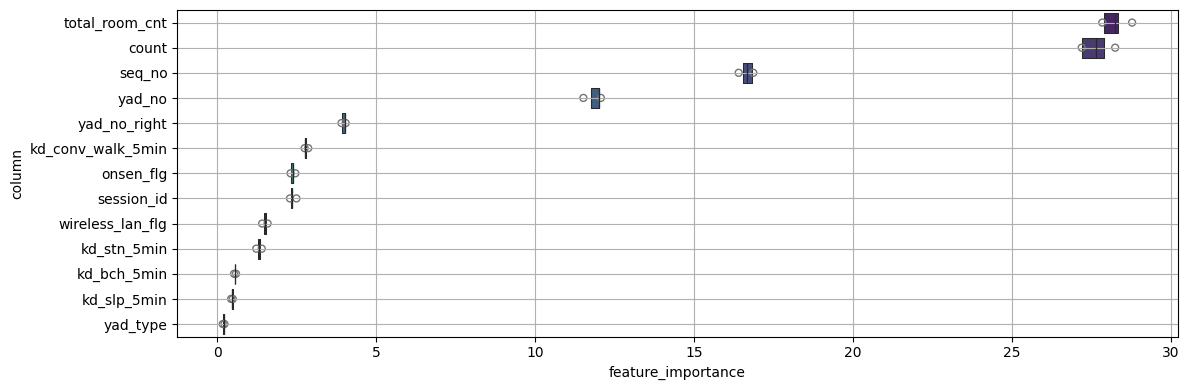

In [113]:
from scorta.eda import df as eda_df

eda_df.visualize_importance(gbdt.feature_importance(), X_train.to_pandas())

In [26]:
top_30_df = (
    convert_ses2idx(dl.load_test_log())
    .with_columns(pl.lit(" ".join(map(str, top30_yad["yad_no"].to_list()))))
    .select(["session_id", "literal"])
    .unique()
    .with_columns(pl.col("literal").str.split(" "))
    .explode("literal")
    .with_columns(pl.col("literal").cast(pl.Int32).alias("yad_no_right"))
    .drop()
)

In [126]:
sub_lists

[[11561, 4714, 4420, 2680, 5466, 4545, 3560, 6563, 9534, 9830],
 [143, 4066, 6555, 7014, 11923, 8108, 6129, 613, 12862, 11237],
 [9190, 7710, 757, 9910, 1774, 13570, 10485, 6721, 9190, 9910],
 [12341, 3359, 6991, 6991, 13521, 13610, 3359, 1542, 12341, 1542],
 [9020, 2862, 10826, 3476, 3844, 3854, 5372, 763, 9623, 6161],
 [13292, 12785, 3811, 10857, 10457, 3701, 855, 8355, 11214, 5066],
 [11776, 1462, 850, 8041, 8691],
 [10904, 11201, 11201, 10119, 7537],
 [3244],
 [5203, 1013, 2322, 1424, 2867, 8364, 11450, 5357, 11586, 4424],
 [8169, 12305, 5076, 1418, 5323, 3271, 6425, 6959, 12598, 4712],
 [12425, 12986, 11037, 6199, 12089, 4614, 12089, 8468, 8468, 11112],
 [6407, 9877, 1510, 5045, 561],
 [289, 7964, 9153, 793, 2166, 4336],
 [1935, 12645, 10827, 5336, 32, 6165, 10710],
 [6693, 5116, 8567, 11711, 6693, 2201, 719, 2687, 1587, 2797],
 [10515, 11407, 5566, 12907, 577, 6086, 6980, 5445, 9301],
 [2399, 1625, 5664, 6984, 2149, 4015, 12393],
 [3769, 9193, 9467, 13453, 10422, 12069, 115, 1133

In [145]:
sub_lists = (
    sub.with_columns(
        pl.col("score").rank(method="ordinal", descending=True).over("session_id").alias("rank") - pl.lit(1)
    )
    .sort(["session_id", "rank"])
    .filter(pl.col("rank") <= 9)
    .group_by("session_id", maintain_order=True)
    .agg("yad_no_right")["yad_no_right"]
    .to_list()
)
test_top30_yads = (
    dl.load_test_log().group_by("yad_no").count().sort("count", descending=True).head(30)["yad_no"].to_list()
)

seened_dict: dict[int, np.ndarray] = (
    convert_ses2idx(dl.load_test_log())
    .with_columns([(pl.col("seq_no").max().over("session_id") == pl.col("seq_no")).alias("is_last")])
    .filter(~pl.col("is_last"))
    .group_by("session_id")
    .agg("yad_no")
    .sort("session_id")
    .to_pandas()
    .set_index("session_id")
    .to_dict()["yad_no"]
)


fill_sub_lists = []
for idx, sub_list in enumerate(sub_lists):
    new_sub_list = []
    if sub_list != [None]:
        new_sub_list.extend(sub_list)

    if len(sub_list) < 10:
        if idx in seened_dict:
            new_sub_list.extend(list(seened_dict[idx]))
        new_sub_list.extend(top_yads[:10])

    if idx == 330:
        print(len(sub_list), sub_list, top_yads[:10])

    fill_sub_lists.append(new_sub_list[:10])

print(sub_lists[:10])
print(fill_sub_lists[:10])

1 [None] [12350, 719, 3338, 13468, 10095, 8567, 532, 8553, 2201, 915]
[[11561, 4714, 4420, 2680, 5466, 4545, 3560, 6563, 9534, 9830], [143, 4066, 6555, 7014, 11923, 8108, 6129, 613, 12862, 11237], [9190, 7710, 757, 9910, 1774, 13570, 10485, 6721, 9190, 9910], [12341, 3359, 6991, 6991, 13521, 13610, 3359, 1542, 12341, 1542], [9020, 2862, 10826, 3476, 3844, 3854, 5372, 763, 9623, 6161], [13292, 12785, 3811, 10857, 10457, 3701, 855, 8355, 11214, 5066], [11776, 1462, 850, 8041, 8691], [10904, 11201, 11201, 10119, 7537], [3244], [5203, 1013, 2322, 1424, 2867, 8364, 11450, 5357, 11586, 4424]]
[[11561, 4714, 4420, 2680, 5466, 4545, 3560, 6563, 9534, 9830], [143, 4066, 6555, 7014, 11923, 8108, 6129, 613, 12862, 11237], [9190, 7710, 757, 9910, 1774, 13570, 10485, 6721, 9190, 9910], [12341, 3359, 6991, 6991, 13521, 13610, 3359, 1542, 12341, 1542], [9020, 2862, 10826, 3476, 3844, 3854, 5372, 763, 9623, 6161], [13292, 12785, 3811, 10857, 10457, 3701, 855, 8355, 11214, 5066], [11776, 1462, 850, 804

In [141]:
top_yads[:10]

[12350, 719, 3338, 13468, 10095, 8567, 532, 8553, 2201, 915]

In [159]:
sample_sub_df = dl.load_sample_submission("pd")
sample_sub_df.loc[:, :] = np.array(fill_sub_lists)
sample_sub_df.to_csv("../output/001_baseline/sub_df.csv", index=False)

In [147]:
fill_sub_lists[330]

[12350, 719, 3338, 13468, 10095, 8567, 532, 8553, 2201, 915]

In [148]:
np.array(fill_sub_lists)

array([[11561,  4714,  4420, ...,  6563,  9534,  9830],
       [  143,  4066,  6555, ...,   613, 12862, 11237],
       [ 9190,  7710,   757, ...,  6721,  9190,  9910],
       ...,
       [13241,  2087,   844, ...,  7379, 11796, 12240],
       [ 3100,  2373,  3002, ...,  5513,  8576, 12281],
       [12767, 10729, 11723, ...,  5623, 11994, 12522]])

In [154]:
df = pd.DataFrame(fill_sub_lists)
df.columns = [f"predict_{i}" for i in range(10)]
df.to_csv()

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,11561,4714,4420,2680,5466,4545,3560,6563,9534,9830
1,143,4066,6555,7014,11923,8108,6129,613,12862,11237
2,9190,7710,757,9910,1774,13570,10485,6721,9190,9910
3,12341,3359,6991,6991,13521,13610,3359,1542,12341,1542
4,9020,2862,10826,3476,3844,3854,5372,763,9623,6161
...,...,...,...,...,...,...,...,...,...,...
174695,11123,7888,1885,1997,8771,5744,7888,10997,9743,7062
174696,13220,4014,12432,1227,3802,899,3644,2164,2232,6874
174697,13241,2087,844,5810,13797,7308,8143,7379,11796,12240
174698,3100,2373,3002,13672,4976,10287,1687,5513,8576,12281


In [60]:
wide_sub = (
    sub.with_columns(
        pl.col("score").rank(method="ordinal", descending=True).over("session_id").alias("rank") - pl.lit(1)
    )
    .sort(["session_id", "rank"])
    .filter(pl.col("rank") <= 9)
    .drop("score")
    .pivot(values="yad_no_right", index="session_id", columns="rank", sort_columns=True)
    .select([pl.col("session_id"), pl.col("^[0-9]$").name.prefix("predict_")])
    .drop("session_id")
)
yads = top30_yad["yad_no"].to_list()
wide_sub = wide_sub.with_columns([pl.col(f"predict_{i}").fill_null(yads[i]) for i in range(10)])

In [62]:
wide_sub.write_csv("001_baseline.csv")

(array([6.610826e+06, 1.739201e+06, 2.215890e+05, 5.489100e+04,
        1.449600e+04, 4.270000e+03, 7.710000e+02, 1.270000e+02,
        1.000000e+01, 1.000000e+01]),
 array([-0.01426086,  0.0345693 ,  0.08339947,  0.13222963,  0.18105979,
         0.22988996,  0.27872011,  0.32755029,  0.37638044,  0.42521062,
         0.47404078]),
 <BarContainer object of 10 artists>)

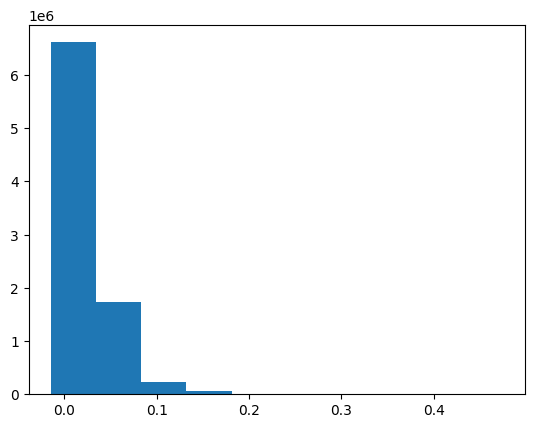

In [29]:
plt.hist(oof)

In [97]:
from scorta.eda import df as eda_df


for key, df in dl.load_all_dfs("pd").items():
    print(key)
    display(eda_df.df_info(df))

sample_submission
Shape: (174700, 10)


/Users/zerebom/Library/Caches/pypoetry/virtualenvs/atma-16-GUsyrwfA-py3.11/lib/python3.11/site-packages/scorta/eda/df.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[12530, 13398, 6598, 8502, 12924, 5979, 3019, 8468, 13270, 681]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[c, f"top{topN} val"] = str(val)
/Users/zerebom/Library/Caches/pypoetry/virtualenvs/atma-16-GUsyrwfA-py3.11/lib/python3.11/site-packages/scorta/eda/df.py:147: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[30, 28, 27, 27, 27, 26, 26, 26, 25, 25]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[c, f"top{topN} cnt"] = str(cnt)
/Users/zerebom/Library/Caches/pypoetry/virtualenvs/atma-16-GUsyrwfA-py3.11/lib/python3.11/site-packages/scorta/eda/df.py:148: FutureWarning: Setting 

,DataType,#Nulls,#Uniques,Min,Mean,Max,Std,top10 val,top10 cnt,top10 raito
predict_0,int64,0,13806,1,6934.829164,13806,3986.741705,"[12530, 13398, 6598, 8502, 12924, 5979, 3019, ...","[30, 28, 27, 27, 27, 26, 26, 26, 25, 25]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
predict_1,int64,0,13806,1,6904.034745,13806,3979.738149,"[2896, 2750, 7496, 4171, 921, 6387, 2546, 8016...","[31, 29, 28, 27, 26, 26, 26, 26, 26, 25]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
predict_2,int64,0,13806,1,6900.383686,13806,3977.319717,"[4933, 8367, 11743, 7042, 13704, 9946, 13497, ...","[28, 28, 27, 27, 26, 26, 26, 26, 25, 25]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
predict_3,int64,0,13806,1,6906.471048,13806,3986.456999,"[9931, 10520, 12774, 12702, 13, 9684, 2185, 13...","[31, 31, 29, 28, 28, 27, 27, 27, 26, 26]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
predict_4,int64,0,13806,1,6914.499777,13806,3983.687011,"[979, 13798, 6633, 12527, 12494, 1564, 5154, 9...","[28, 28, 27, 27, 26, 26, 26, 26, 26, 26]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
predict_5,int64,0,13806,1,6910.886491,13806,3983.552955,"[3322, 8596, 2406, 2504, 8800, 7881, 3649, 957...","[28, 27, 27, 27, 27, 26, 26, 26, 26, 25]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
predict_6,int64,0,13806,1,6895.406732,13806,3991.016373,"[10310, 3560, 5479, 11412, 2180, 636, 2868, 86...","[27, 27, 27, 27, 26, 26, 26, 26, 26, 26]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
predict_7,int64,0,13806,1,6893.918821,13806,3987.310498,"[914, 3697, 6745, 1900, 1380, 7886, 8437, 1112...","[29, 29, 28, 28, 27, 27, 27, 26, 26, 26]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
predict_8,int64,0,13806,1,6920.963137,13806,3988.147395,"[8997, 10908, 814, 8476, 3763, 8579, 7859, 124...","[28, 28, 27, 27, 26, 26, 26, 26, 26, 26]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
predict_9,int64,0,13806,1,6894.600544,13806,3985.273913,"[6152, 655, 6531, 10553, 5072, 12558, 1243, 59...","[29, 29, 28, 27, 27, 26, 26, 26, 26, 25]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


test_session
Shape: (174700, 1)


/Users/zerebom/Library/Caches/pypoetry/virtualenvs/atma-16-GUsyrwfA-py3.11/lib/python3.11/site-packages/scorta/eda/df.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['00001149e9c73985425197104712478c', 'aa76dabd6667e9a4be3db0790c858b5a', 'aa73c6dba624c1f4d07fb0af256ddf0a', 'aa759b4ece92c4bb84d7a308b5bf407b', 'aa75fa6bb908940e575f4ba350ff7939', 'aa760f680ca03f562f79c75505cb84f4', 'aa7614facfdb4cf9e77907a126290feb', 'aa761564e071d7d9868c6593aca45037', 'aa7638100bbcb922704ec54f4ed87ce9', 'aa76abc9f4573c985105706a86f0555d']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[c, f"top{topN} val"] = str(val)
/Users/zerebom/Library/Caches/pypoetry/virtualenvs/atma-16-GUsyrwfA-py3.11/lib/python3.11/site-packages/scorta/eda/df.py:147: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1, 1, 1, 1, 1, 1, 1, 

,DataType,#Nulls,#Uniques,Min,Mean,Max,Std,top10 val,top10 cnt,top10 raito
session_id,object,0,174700,NaN,NaN,NaN,NaN,"['00001149e9c73985425197104712478c', 'aa76dabd...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


image_embeddings
Shape: (178406, 514)


/Users/zerebom/Library/Caches/pypoetry/virtualenvs/atma-16-GUsyrwfA-py3.11/lib/python3.11/site-packages/scorta/eda/df.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[13806, 3641, 3649, 8897, 8900, 3645, 3644, 8906, 8909, 8911]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[c, f"top{topN} val"] = str(val)
/Users/zerebom/Library/Caches/pypoetry/virtualenvs/atma-16-GUsyrwfA-py3.11/lib/python3.11/site-packages/scorta/eda/df.py:147: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[15, 15, 15, 15, 15, 15, 15, 15, 15, 15]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[c, f"top{topN} cnt"] = str(cnt)
/Users/zerebom/Library/Caches/pypoetry/virtualenvs/atma-16-GUsyrwfA-py3.11/lib/python3.11/site-packages/scorta/eda/df.py:148: FutureWarning: Setting an

,DataType,#Nulls,#Uniques,Min,Mean,Max,Std,top10 val,top10 cnt,top10 raito
yad_no,Int64,0,13804,1.0,6904.806783,13806.0,3982.404493,"[13806, 3641, 3649, 8897, 8900, 3645, 3644, 89...","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
category,object,0,5,<NA>,<NA>,<NA>,<NA>,"['exterior', 'room', 'facility', 'others', 'fo...","[37099, 36989, 36932, 34104, 33282]","[0.21, 0.21, 0.21, 0.19, 0.19]"
emb_0,float32,0,165080,-0.129007,-0.001153,0.142385,0.030291,"[-0.008867661468684673, -0.02721918188035488, ...","[642, 591, 374, 220, 201, 195, 192, 184, 175, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
emb_1,float32,0,165057,-0.136465,-0.005524,0.145254,0.030554,"[-0.024315129965543747, -0.04219745099544525, ...","[642, 591, 374, 220, 201, 195, 192, 184, 175, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
emb_2,float32,0,164984,-0.130539,-0.010083,0.124265,0.024336,"[0.010805472731590271, 0.056881170719861984, 0...","[642, 591, 374, 220, 201, 195, 192, 184, 175, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...
emb_507,float32,0,164896,-0.1695,-0.027037,0.131132,0.026046,"[-0.02540210820734501, -0.05450797080993652, -...","[642, 591, 374, 220, 201, 195, 192, 184, 175, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
emb_508,float32,0,165015,-0.138984,-0.015087,0.130973,0.025509,"[0.012642652727663517, -0.026401368901133537, ...","[642, 591, 374, 220, 201, 195, 192, 184, 176, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
emb_509,float32,0,165064,-0.170252,-0.004463,0.165428,0.044118,"[-0.04085739329457283, -0.020482178777456284, ...","[642, 591, 374, 220, 201, 195, 192, 184, 175, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
emb_510,float32,0,165096,-0.153507,0.004489,0.127405,0.027088,"[-0.05990894138813019, -0.032883524894714355, ...","[642, 591, 374, 220, 201, 195, 192, 184, 175, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


test_log
Shape: (250305, 3)


/Users/zerebom/Library/Caches/pypoetry/virtualenvs/atma-16-GUsyrwfA-py3.11/lib/python3.11/site-packages/scorta/eda/df.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['98910176c283049545eb3a8a171dba17', 'beaf391cbaa4612ee9fcf533de745eaa', 'a72fec3aa9f9e29553145550834a907e', '1b4abef5107994cecbfb4c984e7b2e6b', '6cbb4bbac1d77f9bf8b2e80d55fa9d3b', '69aad90decd0aa93d8828bd3bb175d3e', '11c37ffd243700c212ecdb406efb0b9e', '75e6ffc917cbca601a81a65332b5dd50', '40f0457b567360e3b76966bea8c88ba7', '6c014852d6dc4e99b5d5b7b88ac077e7']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[c, f"top{topN} val"] = str(val)
/Users/zerebom/Library/Caches/pypoetry/virtualenvs/atma-16-GUsyrwfA-py3.11/lib/python3.11/site-packages/scorta/eda/df.py:147: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[8, 8, 8, 8, 8, 8, 8, 

,DataType,#Nulls,#Uniques,Min,Mean,Max,Std,top10 val,top10 cnt,top10 raito
session_id,object,0,174700,NaN,NaN,NaN,NaN,"['98910176c283049545eb3a8a171dba17', 'beaf391c...","[8, 8, 8, 8, 8, 8, 8, 7, 7, 7]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
seq_no,int64,0,8,0.0,0.379657,7.0,0.661502,"[0, 1, 2, 3, 4, 5, 6, 7]","[174700, 60760, 11267, 2808, 581, 153, 29, 7]","[0.7, 0.24, 0.05, 0.01, 0.0, 0.0, 0.0, 0.0]"
yad_no,int64,0,11223,1.0,6859.588977,13806.0,3982.391402,"[719, 2201, 13468, 12350, 2797, 6470, 8567, 12...","[683, 530, 494, 491, 469, 467, 421, 409, 402, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


yado
Shape: (13806, 13)


/Users/zerebom/Library/Caches/pypoetry/virtualenvs/atma-16-GUsyrwfA-py3.11/lib/python3.11/site-packages/scorta/eda/df.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1, 9196, 9198, 9199, 9200, 9201, 9202, 9203, 9204, 9205]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[c, f"top{topN} val"] = str(val)
/Users/zerebom/Library/Caches/pypoetry/virtualenvs/atma-16-GUsyrwfA-py3.11/lib/python3.11/site-packages/scorta/eda/df.py:147: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[c, f"top{topN} cnt"] = str(cnt)
/Users/zerebom/Library/Caches/pypoetry/virtualenvs/atma-16-GUsyrwfA-py3.11/lib/python3.11/site-packages/scorta/eda/df.py:148: FutureWarning: Setting an item of incom

,DataType,#Nulls,#Uniques,Min,Mean,Max,Std,top10 val,top10 cnt,top10 raito
yad_no,int64,0,13806,1.0,6903.500000,13806.0,3985.593243,"[1, 9196, 9198, 9199, 9200, 9201, 9202, 9203, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
yad_type,int64,0,2,0.0,0.012024,1.0,0.108996,"[0, 1]","[13640, 166]","[0.99, 0.01]"
total_room_cnt,float64,833,541,0.0,87.854929,2384.0,107.382317,"[10.0, 12.0, 20.0, 15.0, 30.0, 14.0, 18.0, 8.0...","[310, 242, 236, 227, 212, 211, 202, 202, 193, ...","[0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.01, 0.0..."
wireless_lan_flg,float64,2799,1,1.0,1.000000,1.0,0.000000,[1.0],[11007],[0.8]
onsen_flg,int64,0,2,0.0,0.357164,1.0,0.479181,"[0, 1]","[8875, 4931]","[0.64, 0.36]"
kd_stn_5min,float64,8485,1,1.0,1.000000,1.0,0.000000,[1.0],[5321],[0.39]
kd_bch_5min,float64,13018,1,1.0,1.000000,1.0,0.000000,[1.0],[788],[0.06]
kd_slp_5min,float64,13547,1,1.0,1.000000,1.0,0.000000,[1.0],[259],[0.02]
kd_conv_walk_5min,float64,5452,1,1.0,1.000000,1.0,0.000000,[1.0],[8354],[0.61]
wid_cd,object,0,12,NaN,NaN,NaN,NaN,"['46e33861f921c3e38b81998fbf283f01', 'f0112abf...","[2268, 1884, 1664, 1659, 1198, 1101, 914, 855,...","[0.16, 0.14, 0.12, 0.12, 0.09, 0.08, 0.07, 0.0..."


train_log
Shape: (419270, 3)


/Users/zerebom/Library/Caches/pypoetry/virtualenvs/atma-16-GUsyrwfA-py3.11/lib/python3.11/site-packages/scorta/eda/df.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['734cc105dc165cc485341e367b3c70ab', '2b85ae2747e0fcf10b79729f992175c3', 'c2ba59a9eca4ff52f466793b7ce9a03a', 'b53c08ff65393979515bf5197ab445a6', '11fc99d6128427fd688ae8ec67127146', 'a5b275c42cf27ae7a4cec688bb82a597', '9a96088893ca29d78be72229099c13c7', 'cb37aa9226c4e5e8d0da063eeef5b0c6', 'b41cff74cb0e1e423cf7fc40a8355d3f', '8436c27ffad4c00d911ace8b0f274552']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[c, f"top{topN} val"] = str(val)
/Users/zerebom/Library/Caches/pypoetry/virtualenvs/atma-16-GUsyrwfA-py3.11/lib/python3.11/site-packages/scorta/eda/df.py:147: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[10, 9, 9, 9, 9, 8, 8,

,DataType,#Nulls,#Uniques,Min,Mean,Max,Std,top10 val,top10 cnt,top10 raito
session_id,object,0,288698,NaN,NaN,NaN,NaN,"['734cc105dc165cc485341e367b3c70ab', '2b85ae27...","[10, 9, 9, 9, 9, 8, 8, 8, 8, 8]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
seq_no,int64,0,10,0.0,0.397658,9.0,0.684395,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[288698, 103312, 20519, 5169, 1144, 311, 88, 2...","[0.69, 0.25, 0.05, 0.01, 0.0, 0.0, 0.0, 0.0, 0..."
yad_no,int64,0,13372,2.0,6879.812331,13806.0,4018.859073,"[3338, 12350, 10095, 13468, 8567, 719, 532, 85...","[1422, 1115, 946, 879, 843, 837, 819, 795, 752...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


train_label
Shape: (288698, 2)


/Users/zerebom/Library/Caches/pypoetry/virtualenvs/atma-16-GUsyrwfA-py3.11/lib/python3.11/site-packages/scorta/eda/df.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['000007603d533d30453cc45d0f3d119f', 'aab35b6d85ae4f97c2560285f1a9e4f3', 'aab5634e9b944aedd41a125d079126b2', 'aab5432c309faac0335965cf67ac53d1', 'aab533d82c140054fc43a44811f6687e', 'aab4edc3f53d3c23117177f86127bfb6', 'aab410590596842b97303053840dc4fb', 'aab3e2e90882e8d72f8270383999b5d2', 'aab330280653a0c2b4abdb6057681266', 'aab61f30fa0df84b36a02643ca2a36a8']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[c, f"top{topN} val"] = str(val)
/Users/zerebom/Library/Caches/pypoetry/virtualenvs/atma-16-GUsyrwfA-py3.11/lib/python3.11/site-packages/scorta/eda/df.py:147: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1, 1, 1, 1, 1, 1, 1, 

,DataType,#Nulls,#Uniques,Min,Mean,Max,Std,top10 val,top10 cnt,top10 raito
session_id,object,0,288698,NaN,NaN,NaN,NaN,"['000007603d533d30453cc45d0f3d119f', 'aab35b6d...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
yad_no,int64,0,12381,1.0,6896.405555,13806.0,4015.333265,"[10095, 3338, 12350, 8553, 385, 13017, 719, 38...","[605, 576, 533, 427, 347, 340, 299, 294, 290, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [4]:
yado = dl.load_yado()

In [12]:
yado.head()

yad_no,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd,ken_cd,lrg_cd,sml_cd
i64,i64,f64,f64,i64,f64,f64,f64,f64,str,str,str,str
1,0,129.0,1.0,0,1.0,null,null,1.0,"""f0112abf369fb0…","""072c85e1653e10…","""449c52ef581d5f…","""677a32689cd1ad…"
2,0,23.0,1.0,0,null,null,null,null,"""d86102dd9c232b…","""b4d2fb4e51ea7b…","""5c9a8f48e9df02…","""4ee16ee838dd27…"
3,0,167.0,1.0,1,1.0,null,null,1.0,"""46e33861f921c3…","""572d60f0f5212a…","""8a623b960557e8…","""ab9480fd72a44d…"
4,0,144.0,1.0,0,1.0,null,null,1.0,"""46e33861f921c3…","""107c7305a74c8d…","""52c9ea83f2cfe9…","""1cc3e1838bb0fd…"
5,0,41.0,1.0,1,null,null,null,null,"""43875109d1dab9…","""75617bb07a2785…","""9ea5a911019b66…","""be1b876af18afc…"
